In [1]:
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset
import pandas as pd

In [2]:
source_url = "/lustre/storeB/project/fou/hi/FjordOs/fjordos2_hindcast/v6/exp1/ocean_his_0007.nc4"
nc = Dataset(source_url)
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 898, eta_rho: 899, eta_u: 899, eta_v: 898, ocean_time: 720, s_rho: 42, s_w: 43, tracer: 2, xi_psi: 298, xi_rho: 299, xi_u: 298, xi_v: 299)
Coordinates:
    lat_psi         (eta_psi, xi_psi) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lon_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-...
  * s_rho           (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w             (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/99)
    AKt             (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKv             (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    Akk_bak         float64 ...
    Akp_bak         float64 ...
    Akt_bak         (tracer) float64 ...
    Akv_bak         float64 ...
    ...              ...
    v               (ocean_time, s_rho, eta_v, xi_v) float32 ...
    v_northward     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    vbar            (ocean_time, eta_v, xi_v) float32 ...
    w               (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    xl              float64 ...
    zeta            (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:              /lustre/storeB/users/nilsmk/metroms_run/fjordos_hindca...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             ROMS
    var_info:          /home/nilsmk/metroms_apps/fjordos_hindcast/include/var...
    ...                ...
    compiler_flags:    -xHost  -free -free
    tiling:            004x036
    history:           Wed Jan 22 16:28:40 2020: ncks -O --4 -L 3 ocean_his_0...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       FJORDOS, ADD_FSOBC, ADD_M2OBC, ALBEDO, ANA_BSFLUX, ANA...
    NCO:               netCDF Operators version 4.8.0 (Homepage = http://nco....

In [3]:
from gpuocean.utils import WindStress

def generate_wind_field(wind_angle_deg, t_start_index, T):
    """Generating WindStress object with spatially constant, hourly varying wind 
    according to the standard shape in Oslofjord (see Oslofjord-ArtificialParameters.ipynb)
    
    wind_angle_deg - angle of wind field towards north in degree!
    t_start_index  - index for the time when generated wind field is supposed to start
    T              - time span for which the wind field is generated 
    """

    wind_angle = np.deg2rad(wind_angle_deg)

    # Reference wind speed for 0 - 24h 
    wind_u_ref = np.zeros(24)
    wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
    wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

    # Wind fields for 0 - 24h
    wind_u = list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))
    wind_v = list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))

    # Shifting that reference hours align with t_0
    shift = datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start_index]).hour
    for shift_hour in range(shift):
        wind_u.append(wind_u.pop(0))
        wind_v.append(wind_v.pop(0))
    
    # Repeat for several days if necessary
    wind_u = wind_u * int(np.ceil((T/3600+1)/24))
    wind_v = wind_v * int(np.ceil((T/3600+1)/24))
    
    # Cut relevant time span
    wind_u = wind_u[0:int(T/3600+1)]
    wind_v = wind_v[0:int(T/3600 +1)]

    # Construct time array in simulator time (starting with 0)
    ts = np.arange(T+1, step=3600)

    # Init WindStress object
    wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
    wind.compute_wind_stress_from_wind()

    return wind 

In [15]:
t_start = 5*24 + 20 #285
t_stop =  t_start + 6
T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

print(len(timestep_indices[0]))
print(timestep_indices)

7
[[140, 141, 142, 143, 144, 145, 146]]


In [17]:
# This could perhaps be done a bit less messy... but maybe not?!

timestep = ds.ocean_time[timestep_indices[0]].values
print(timestep)

timestep = pd.to_datetime(timestep)
print(timestep)

time = [element.to_pydatetime() for element in timestep]
print(time)

['2014-07-06T09:00:00.000000000' '2014-07-06T10:00:00.000000000'
 '2014-07-06T11:00:00.000000000' '2014-07-06T12:00:00.000000000'
 '2014-07-06T13:00:00.000000000' '2014-07-06T14:00:00.000000000'
 '2014-07-06T15:00:00.000000000']
DatetimeIndex(['2014-07-06 09:00:00', '2014-07-06 10:00:00',
               '2014-07-06 11:00:00', '2014-07-06 12:00:00',
               '2014-07-06 13:00:00', '2014-07-06 14:00:00',
               '2014-07-06 15:00:00'],
              dtype='datetime64[ns]', freq=None)
[datetime.datetime(2014, 7, 6, 9, 0), datetime.datetime(2014, 7, 6, 10, 0), datetime.datetime(2014, 7, 6, 11, 0), datetime.datetime(2014, 7, 6, 12, 0), datetime.datetime(2014, 7, 6, 13, 0), datetime.datetime(2014, 7, 6, 14, 0), datetime.datetime(2014, 7, 6, 15, 0)]


In [18]:
ref_wind_direction = 45.0
ref_wind = generate_wind_field(ref_wind_direction, t_start, T)

In [19]:
print(len(ref_wind.wind_u))
print(ref_wind.wind_u)
x_wind = [element.tolist()[0][0] for element in ref_wind.wind_u]
print(x_wind)

print(len(ref_wind.wind_v))
print(ref_wind.wind_v)
y_wind = [element.tolist()[0][0] for element in ref_wind.wind_v]
print(y_wind)

7
[array([[-0.06752269]], dtype=float32), array([[0.]], dtype=float32), array([[0.35012794]], dtype=float32), array([[1.3311645]], dtype=float32), array([[2.7488036]], dtype=float32), array([[4.322264]], dtype=float32), array([[5.739903]], dtype=float32)]
[-0.06752268970012665, 0.0, 0.3501279354095459, 1.3311644792556763, 2.7488036155700684, 4.322264194488525, 5.739902973175049]
7
[array([[-0.06752269]], dtype=float32), array([[0.]], dtype=float32), array([[0.35012794]], dtype=float32), array([[1.3311645]], dtype=float32), array([[2.7488036]], dtype=float32), array([[4.322264]], dtype=float32), array([[5.739903]], dtype=float32)]
[-0.06752268970012665, 0.0, 0.3501279354095459, 1.3311644792556763, 2.7488036155700684, 4.322264194488525, 5.739902973175049]


In [20]:
opendrift_wind = {}

opendrift_wind["time"] = time
opendrift_wind["x_wind"] = x_wind
opendrift_wind["y_wind"] = y_wind

print(opendrift_wind)

{'time': [datetime.datetime(2014, 7, 6, 9, 0), datetime.datetime(2014, 7, 6, 10, 0), datetime.datetime(2014, 7, 6, 11, 0), datetime.datetime(2014, 7, 6, 12, 0), datetime.datetime(2014, 7, 6, 13, 0), datetime.datetime(2014, 7, 6, 14, 0), datetime.datetime(2014, 7, 6, 15, 0)], 'x_wind': [-0.06752268970012665, 0.0, 0.3501279354095459, 1.3311644792556763, 2.7488036155700684, 4.322264194488525, 5.739902973175049], 'y_wind': [-0.06752268970012665, 0.0, 0.3501279354095459, 1.3311644792556763, 2.7488036155700684, 4.322264194488525, 5.739902973175049]}


In [21]:
# write time, x_wind and y_wind to file

import pickle

with open("fjordos_opendrift_wind.pickle", "wb") as f:
    pickle.dump(opendrift_wind, f, protocol=4)

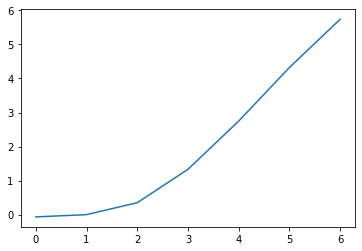

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(x_wind)